# Recipe2Cuisine

Data Challenge: July 19, 2020
Candidate: Isaac Chung\
Time alloted: 4 hours\
Task: 1) Design and execute a method to predict the cuisine of a recipe given only its ingredients. How could you design this to be robust enough to understand similarities / substitutions between ingredients? 2) For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. 3) How would you go about writing this guide for a few major cuisines?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 0. Import data
First let's import the data set, and see what's inside. Data is given in a json file. Let's use pandas' read_json function.

In [2]:
data = pd.read_json("recipies.json") 

We have cuisine as class labels, and list of ingredients for each recipe id. It is safe to assume that this column does not have instructions, so if we need to do parts-of-speech tagging, verb might not be needed.

At first glance, the data does not require additional cleaning/tokenizing methods like stemming, lemmatizing, or removing symbols, for instance $ or @. 

In [3]:
data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## 1. Initial Data Analysis:
1. Data set shape, types
2. NaN values
3. Duplicates

### 1.1 Data set shape and types
Let's see what the shape and type of the data we have. We are working with just under 40,000 recipes. It does not seem like there are missing values.

In [4]:
print(data.shape)
print(data.info())

(39774, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


### 1.2 Check for NaN values
Looks good so far.

In [5]:
data.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

### 1.3 Check for duplicate values
Looks good as well!

In [6]:
data.id.duplicated().sum()

0

Let's drop the id column as its use is complete.

In [7]:
data.drop(columns='id', inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cuisine      39774 non-null  object
 1   ingredients  39774 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB


## 2. Exploratory Data Analysis

### 2.1 Cuisine counts
There are 20 classes, and they are imbalanced. Italian and Mexican cuisines are the top two majority classes.

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


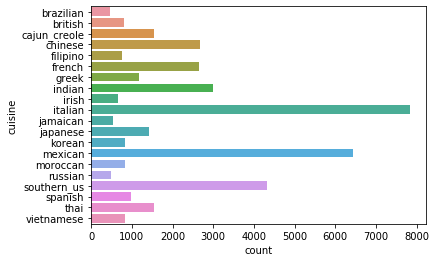

In [9]:
print(data.cuisine.value_counts())
sns.countplot(y=data.cuisine.sort_values())

### 2.2 Ingredients frequency
Now let's find out how often these ingredients are used in the recipes. Let's define a master ingredients list. The following method might not be the most optimal, but it gets the job done for now. Then let's see the top 20 ingredients across all cruisines.

In [10]:
ingredient_list = list()
for index, row in data.iterrows():
    ingredient_list.extend(row['ingredients'])

In [11]:
glist = pd.Series(ingredient_list, dtype=str)

We can pick out quickly the top 20 most frequently used ingredients include variants of salt and water. These ingredients are most likely not informative for predicting cuisines. Note that the presence of olive oil might suggest some bias towards italian cooking.

In [12]:
glist.value_counts().head(20)

salt                   18049
onions                  7972
olive oil               7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
dtype: int64

We can also look at the least frequently used ingredients. Looks like the ingredients below are only mentioned once, in one recipe. There are some brand names included, which might not be something we want to encode, e.g. "Soy Vay® Veri Veri Teriyaki®", "DeLallo", and "KRAFT". This is because these ingredients may be recipe-specific, but not cuisine-specific, meaning they might not all be representative of what the cuisines are generally composed of.

In [13]:
glist.value_counts(ascending=True).head(20)

pippin apples                                1
date molasses                                1
hot fudge topping                            1
hazelnut flour                               1
lipton recip secret golden onion soup mix    1
chocolate milk                               1
ngo gai                                      1
instant chicken bouillon                     1
pearl rice                                   1
sunflower kernels                            1
frozen seafood                               1
loose leaf black tea                         1
soy-based liquid seasoning                   1
hubbard squash                               1
gluten-free oyster sauce                     1
saba                                         1
longaniza                                    1
goat milk feta                               1
Louisiana Cajun Seasoning                    1
dragon fruit                                 1
dtype: int64

Moving forward, we could treat the minimum frequency of ingredients as a tunable hyperparameter. Here I am choosing 1% of the 2nd and 3rd  most frequent counts (79). Given more time, I would write a custom class to implement the fit method for this to be in a sklearn pipeline.

In [14]:
min_freq = 79
mask = glist.isin(glist.value_counts()[glist.value_counts() > min_freq].index)
glist = glist[mask]

### 2.3 Ingredients count
We can count the number of ingredients per recipe, and see the distributions of counts across cuisines.

In [15]:
data['num_in'] = data.ingredients.map(lambda x: len(x))

In [16]:
data.groupby(['cuisine'])['num_in'].describe()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


We could also visualize these results on a boxplot. Note that the horizontal line shown in the boxes are medians.

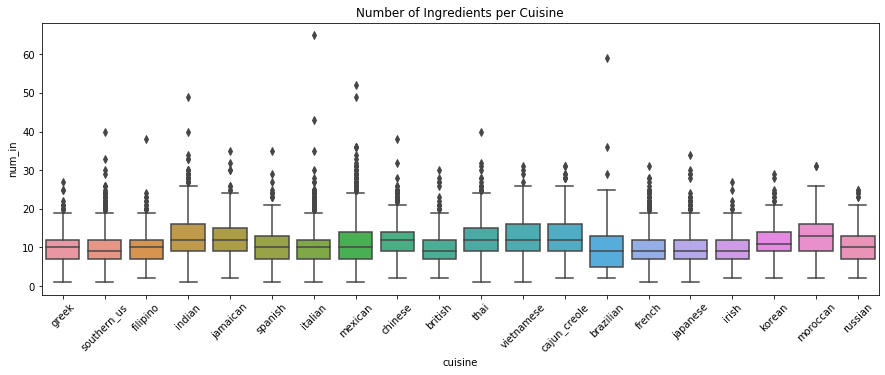

In [17]:
plt.figure(figsize=(15,5))
plt.title('Number of Ingredients per Cuisine')
ax = sns.boxplot(x="cuisine", y="num_in", data=data)
plt.xticks(rotation=45)
plt.show()

In [18]:
def join_list(text_list):
    return " ".join(text_list)

In [19]:
data['joined'] = data['ingredients'].apply(join_list)

In [20]:
data.head()

,cuisine,ingredients,num_in,joined
0,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olives grape tomatoes ga...
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomatoes ground...
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,eggs pepper salt mayonaise cooking oil green c...
3,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallots cornflour cayenne pepper...


## 3. Feature Engineering
We have some ingredients that are shared among cuisines, and some ingredients that are unique to some cuisines.  Since the list of ingredients can be read in no particular order (word order does not matter), we can get a bag-of-words (BOW) model. I am opting for a simple method by using TF-IDF.

From [tfidf.com](http://www.tfidf.com/), "Tf-idf stands for term frequency-inverse document frequency. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus." Here our recipes would be our 'documents'.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

We want to convert all text to lowercase. Scikit-learn's TfidfVectorizer, which is equivalent to applying the CountVectorizer followed by TfidfTransformer, can do this as well. We can use the default options. As for the vocabulary, using the ingredients frequency results, we should drop 'salt' and 'water'. 

In [22]:
glist.count()

367999

In [23]:
glist = glist[~glist.isin(['salt','water'])]
glist.count()

342493

We want the BOW model to include unique vocabularies from the corpus.

In [24]:
unique_vocab = glist.drop_duplicates().tolist()
vectorizer = TfidfVectorizer(vocabulary=unique_vocab)
t_matrix = vectorizer.fit_transform(data.joined).toarray()

In [25]:
len(vectorizer.vocabulary_)

729

In [26]:
t_matrix.shape

(39774, 729)

In [27]:
t_matrix.dtype

dtype('float64')

We have quite a large matrix on hand. It is using 64bits (8 bytes) * 39774 * 6712 = 1.99 GB.\
One way to reduce this dimension is to do some more cleaning using the earlier studies regarding ingredient frequencies and number of ingredients per recipe.

## 4. Modeling 

### 4.1 Naive Bayes
NB is a common model used for text classification. Here a strong assumption is made where the features are conditionally independent given the class label. Before we load the model, we should encode the class labels, and split the data into train-test splits (80-20). 

Note that *multinomial NB* should be used here since we are dealing with discrete variables. Gaussian NB is more suitable for continuous variables which probabilities can be modeled using a Gaussian distribution. 

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(data.cuisine)
data.head()

,cuisine,ingredients,num_in,joined,encoded
0,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olives grape tomatoes ga...,6
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomatoes ground...,16
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,eggs pepper salt mayonaise cooking oil green c...,4
3,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt,7
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallots cornflour cayenne pepper...,7


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(t_matrix, data.encoded, test_size=0.2, stratify=data.encoded)

In [30]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(X_train, y_train)

#### Model Validation
We can first look at the accuracy scores.

In [31]:
from sklearn.metrics import accuracy_score

y_pred_mnb = mnb.predict(X_test)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print("Accuracy MNB: %.2f%%" % (accuracy_mnb * 100.0))

Accuracy MNB: 60.55%


### 4.2 Support Vector Machine
SVM is another common model for text classification. Let's start with the linear kernel.

In [32]:
from sklearn.svm import LinearSVC
svc = LinearSVC().fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Accuracy SVC: %.2f%%" % (accuracy_svc * 100.0))

Accuracy SVC: 66.40%


## 5. Insights
Let's extract some insight from the confusion matrix.

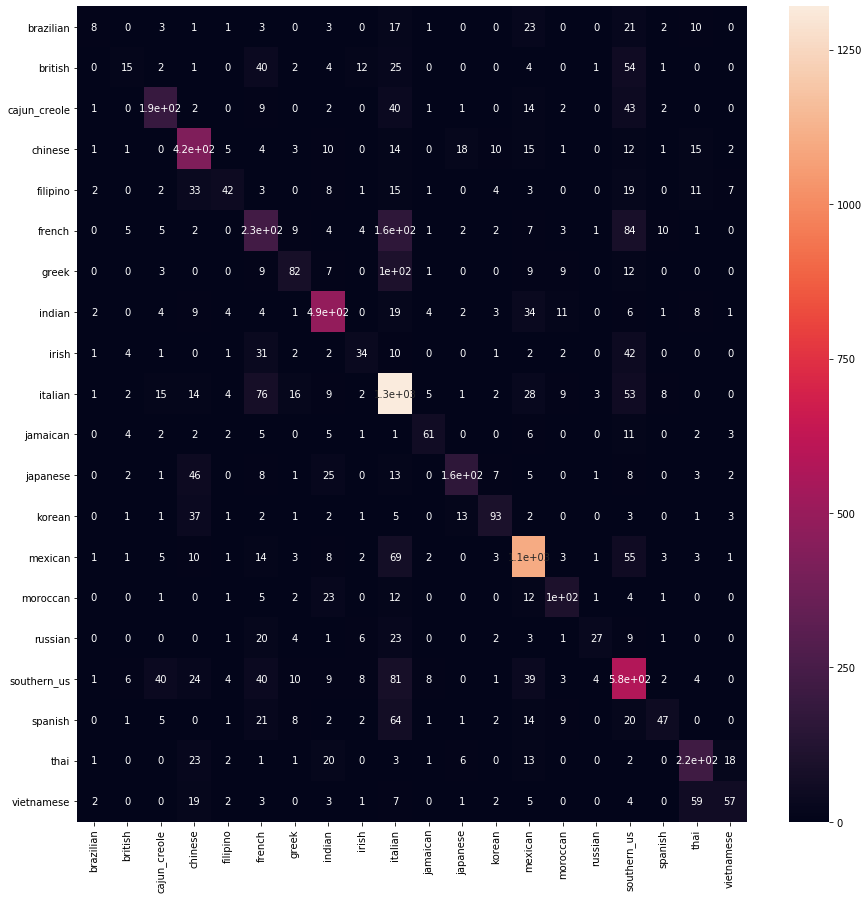

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(15,15))
sns.heatmap(pd.DataFrame(cm, index=encoder.classes_, 
                         columns=encoder.classes_,),
                         annot=True)

I am running out of time at this point. Let's recap the 3 tasks.

### 1) We want to predict the cuisine of a recipe given only its ingredients. 
Using sklearn's linearSVC, we are able to predict with 66% accuracy. Given more time, I will investigate a) further work with feature engineering such as varying the number of ingredients and minimum frequency, b) the use of cross validation, and c) the use of deep learning methods. 

### 2) For each each major cuisine, what are the driving ingredients that characterize it?
This can be found with topic modelling techniques such as LDA (but it's unsupervised). we can also look at the trained model coefficients and see which ingredients have the largest weights for each cuisine. Here we see the top 5 ingredients for cajun_creole. 

In [34]:
svc.coef_.shape

(20, 729)

In [35]:
print("Cuisine :", encoder.classes_[2])
idx = svc.coef_[2,:].argsort()[-5:][::-1]
for i in range(len(idx)):
    print(unique_vocab[idx[i]])

Cuisine : cajun_creole
seasoning
celery
crawfish
okra
shrimp


### 3) How would you go about writing this guide for a few major cuisines?
Given the confusion matrix, we can see a few major cluster of cuisines that use similar ingredients, such as the south Asian (chinese, thai, vietnamese) and Mexican-Southern_US-Cajun_creole. I think tht this guide would start with clustering the remaining recipes into one of these bigger major cuisine groups, then within those groups, use the ingredients that are unique to certain cuisines to label them.